In [1]:
from dotenv import load_dotenv, find_dotenv 

load_dotenv(find_dotenv(), override = True)

True

In [2]:
from langchain_exa import ExaSearchRetriever

exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "keyword") 

In [39]:
output =  exa_search_retriever.invoke("games, premier league") 

print(output)

[Document(metadata={'title': 'Premier League Football News, Fixtures, Scores & Results', 'url': 'https://www.premierleague.com/', 'id': 'https://www.premierleague.com/', 'score': 0.15497928857803345, 'published_date': '2023-02-23T00:00:00.000Z', 'author': ''}, page_content='Video\n \n Ten of the best SUMMER SIGNINGS in Premier League history\n  \nAs the transfer window officially opens, we look back at the greatest ever signings, featuring Ronaldo, Salah, Kante and Henry')]


In [3]:
from langchain_openai import ChatOpenAI 

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)

In [4]:
from typing_extensions import TypedDict 
from typing import Annotated 
from operator import add 

class Custom_State(TypedDict): 
    question: str 
    answer: str 
    messages: Annotated[list[str], add]

In [23]:
def exa_search_tool_1(keywords: str):
    """Search for context from online sources. 
    This search should use keywords as the input.
    
    Args: 
        keywords: input message
    """
    exa_search_retriever = ExaSearchRetriever(k = 1, highlights = False, type = "keyword") 
    output = exa_search_retriever.invoke(keywords) 
    return output[0].page_content

In [6]:
def exa_search_tool_2(keywords: str):
    
    """Search for context from online sources. 
    This search should use keywords as the input.
    
    Args: 
        keywords: input message
    """
    
    return exa_search_retriever.invoke(keywords)[0].page_content

In [7]:
from langchain_core.prompts import PromptTemplate 
from langchain_core.runnables import RunnableLambda
from typing import List
from langchain.tools import tool


def exa_search_tool_3(query: str) -> List[str]:
    """Function to retrieve usable documents for AI assistant"""
    # Initialize the Exa Search retriever
    retriever = ExaSearchRetriever(k=1, highlights=True, use_autoprompt=True)

    # Define how to extract relevant metadata from the search results
    document_prompt = PromptTemplate.from_template(
        """
    <source>
        <url>{url}</url>
        <highlights>{highlights}</highlights>
    </source>
    """
    )

    # Create a chain to process the retrieved documents
    document_chain = (
        RunnableLambda(
            lambda document: {
                "highlights": document.metadata.get("highlights", "No highlights"),
                "url": document.metadata["url"],
            }
        )
        | document_prompt
    )

    # Execute the retrieval and processing chain
    retrieval_chain = retriever | document_chain.map()

    # Retrieve and return the documents
    documents = retrieval_chain.invoke(query)
    return documents

In [24]:
# tools = [retrieve_web_content] 

llm_with_tools = ChatOpenAI(model = "gpt-4o-mini", temperature = 0).bind_tools([exa_search_tool_1])

# print(exa_search_tool("what is the current weather in San Francisco?"))

In [25]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant_node(state: MessagesState): 
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [26]:
def tool_conditional_edge(state: MessagesState): 
    if hasattr(state["messages"][-1], "tool_calls") and len(state["messages"][-1].tool_calls) > 0: 
        return "exa_tool"  
    else: 
        return END

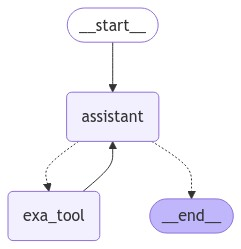

In [29]:
from IPython.display import Image, display
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant_node) 
builder.add_node("exa_tool", ToolNode([exa_search_tool_1]))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tool_conditional_edge)
builder.add_edge("exa_tool", "assistant") 

graph = builder.compile() 

display(Image(graph.get_graph(xray = True).draw_mermaid_png()))

In [30]:
messages = [HumanMessage(content = "premier league games, October 2024")] 
complete_message = graph.invoke({"messages": messages})

In [31]:
print(complete_message) 
print("-" * 50) 
print(complete_message["messages"][-1].content)

{'messages': [HumanMessage(content='premier league games, October 2024', additional_kwargs={}, response_metadata={}, id='30077813-4672-4c24-83d2-df4a6922dac8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RA4zgEVmHKzf8aL5cAaMhfWr', 'function': {'arguments': '{"keywords":"Premier League fixtures October 2024"}', 'name': 'exa_search_tool_1'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 85, 'total_tokens': 109, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-43dba22e-e6e7-46a9-99ba-fe1e1ca08bd1-0', tool_calls=[{'name': 'exa_search_tool_1', 'args': {'keywords': 'Premier League fixtures October 2024'}, 'id': 'call_RA4zgEVmHKzf8aL5cAaMhfWr', 'type': 'tool_call'}], 

# Second Graph (From Exa Documentation)

In [12]:
llm_with_tools_2 = ChatOpenAI(model = "gpt-4o-mini", temperature = 0).bind_tools([exa_search_tool_3])

In [13]:
# Determine whether to continue or end
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    return "tools" if last_message.tool_calls else END


# Function to generate model responses
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools_2.invoke(messages)
    return {"messages": [response]}

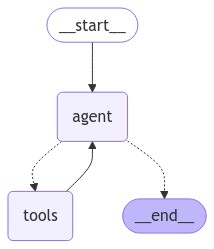

In [14]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode([exa_search_tool_3]))
workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

graph_2 = workflow.compile()

display(Image(graph_2.get_graph(xray = True).draw_mermaid_png()))

In [15]:
final_state = graph_2.invoke({"messages": [HumanMessage(content="Latest premier league games")]})
print(final_state["messages"][-1].content)

I couldn't find the latest results specifically for Premier League games. However, you can check the latest updates on the Premier League by visiting sports news websites or the official Premier League site. If you have a specific match or team in mind, let me know, and I can help you find more detailed information!
